<a href="https://colab.research.google.com/github/wheemin-2/25-1-ESAA/blob/main/0519_HW_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **합성곱 신경망**

# fashion_mnist 데이터셋을 활용한 합성곱 신경망 구현

*fashion_mnist 데이터셋 설명

- 토치비전(torchvision)에 내장된 예제 데이터
- 운동화, 셔츠, 샌들 같은 작은 이미지의 모음이며, 10가지로 분류될 수 있는 28*28 픽셀의 이미지 7만 개로 구성
- train_images : 0~255 사이의 값을 갖는 28*28 크기의 넘파이 배열
- test_labels : 0~9까지 정수 값을 갖는 배열

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn  as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms  # 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

## **데이터셋 내려받기**

In [4]:
# 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('../chap05/data', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('../chap05/data', download=True, train=False,
                                                  transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.99MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.70MB/s]


In [5]:
# fashion_mnist 데이터를 데이터로더에 전달 (메모리로 불러오기 위함)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

`torch.utils.data.DataLoaer()`를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록(shuffle) 할 수 있음
- batch_size=100으로 지정하면 100개 단위로 데이터를 묶어서 불러옴

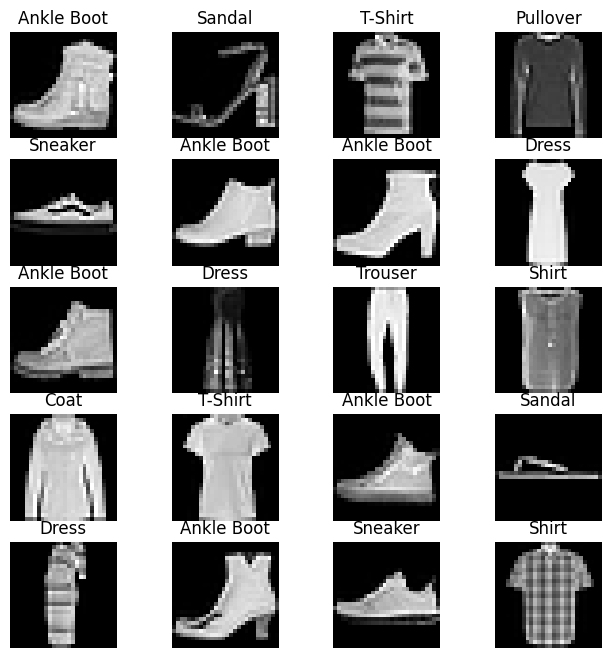

In [6]:
# 분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1:'Trouser', 2:'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',
              6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()  # 20개의 이미지 데이터를 시각적으로 표현

## **심층 신경망 모델 생성**

합성곱 신경망 아님

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

`nn.functional.relu()`와 `nn.ReLU()`의 차이

- 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능
    - `F.relu()`를 forward 함수에서 정의 : input, weight 자체를 직접 정의해야 함
    - `nn.ReLU()`를 __init()__ 함수에서 정의

In [8]:
# nn.ReLU를 사용한 코드
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1,1,3)

In [9]:
# nn.functional을 사용한 코드
import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64,3,3,3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)

심층 신경망 파라미터 정의 / 모델 학습

In [10]:
# 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)  # 생성한 심층 신경망 모델 출력

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
# 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.6124570965766907, Accuracy: 82.94000244140625%
Iteration: 1000, Loss: 0.4818945825099945, Accuracy: 84.16000366210938%
Iteration: 1500, Loss: 0.34125110507011414, Accuracy: 83.52999877929688%
Iteration: 2000, Loss: 0.36464065313339233, Accuracy: 85.36000061035156%
Iteration: 2500, Loss: 0.28170719742774963, Accuracy: 86.30000305175781%
Iteration: 3000, Loss: 0.29387030005455017, Accuracy: 85.80999755859375%


## **합성곱 네트워크 생성**

In [17]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

(코드 설명)

`nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)`
- in_channels : 입력 채널의 수를 의미, 흑백 이미지는 1 / RGB 값을 가진 이미지는 3
- out_channels : 출력 채널의 수
- kernel_size : 커널의 크기를 의미 (논문에 따라서는 필터라고도 함)
    - 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산
    - kernel_size = 3 : 커널의 크기는 (3,3), 직사각형을 사용하고 싶은 경우 (3,5)처럼 지정

`BatchNorm2d` : 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미

![batchNorm2d](https://thebook.io/img/080289/195_2.jpg)

`nn.MaxPool2d(kernel_size=2, stride=2)`
- 풀링 계층 : 합성곱층의 출력 데이터를 입력으로 받아 그 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용됨
- 최대 풀링, 평균 풀링, 최소 풀링 등이 있음
- kernel_size : (m, n) 행렬로 구성된 가중치
- stride : 이동할 간격, 이 값이 커지면 출력 크기는 작아짐

`nn.Linear(in_Features=64*6*6)`
- 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야 함
- in_features : 입력 데이터 크기 (Conv2d, MaxPool2d 수행 후 크기)



**[Conv2d 계층에서의 출력 크기 구하는 공식]**

출력 크기 : $(W-F+2P)/S + 1$
- W : 입력 데이터의 크기
- F : 커널 크기 (kernel_size)
- P : 패딩 크기
- S : 스트라이드

ex) `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)`

출력 크기 : $(28-3+2*1)/1 + 1 = 28$
- 입력 데이터 크기 W 가 28 (Fashion_mnist의 입력 크기가 28*28로 정방형)
- stride의 기본값 (1,1)
- 결과적으로 [32,28,28] 형태가 출력됨


**[MaxPool2d 계층에서의 출력 크기 구하는 공식]**

출력 크기 : $IF/F$
- IF : 입력 필터의 크기 (= 바로 앞의 Conv2d의 출력 크기)
- F : 커널 크기

ex) `nn.MaxPool2d(kernel_size=2, stride=2)`

출력 크기 : $784/2=392$
- 784 (=28*28) : 앞의 Conv2d의 출력 크기
- 결과적으로 [32,392,392] 출력 (32 : Conv2d의 out_channels 수)

In [18]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [19]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5626501441001892, Accuracy: 86.75%
Iteration: 1000, Loss: 0.34142056107521057, Accuracy: 87.9800033569336%
Iteration: 1500, Loss: 0.2467889040708542, Accuracy: 88.7300033569336%
Iteration: 2000, Loss: 0.23310445249080658, Accuracy: 89.36000061035156%
Iteration: 2500, Loss: 0.13512396812438965, Accuracy: 89.26000213623047%
Iteration: 3000, Loss: 0.16928346455097198, Accuracy: 89.87000274658203%
